In [1]:
import warnings

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplfinance as mpf

from yahoo_fin_api import load_df
from fin_viz import candlechart
from denoising.traditional_denoising import moving_avg, exp_moving_avg, bilateral_filter

%matplotlib inline
warnings.filterwarnings(action='ignore')

In [2]:
df = load_df('data/snp.csv')

In [3]:
ma_filtered = moving_avg(df['Mean'], window=300)
ema_filtered = exp_moving_avg(df['Mean'], adjust=False, span=100)
bilateral_filtered = bilateral_filter(df['Mean'], window=301, sigma_d=100, sigma_i=1000)

bilateral_filtered = pd.Series(bilateral_filtered, index=df.index)

In [6]:
trad_filt_df = pd.DataFrame()
trad_filt_df['ma_filtered'] = ma_filtered
trad_filt_df['ema_filtered'] = ema_filtered
trad_filt_df['bilateral_filtered'] = bilateral_filtered
trad_filt_df.to_csv('trad_filter_df.csv')

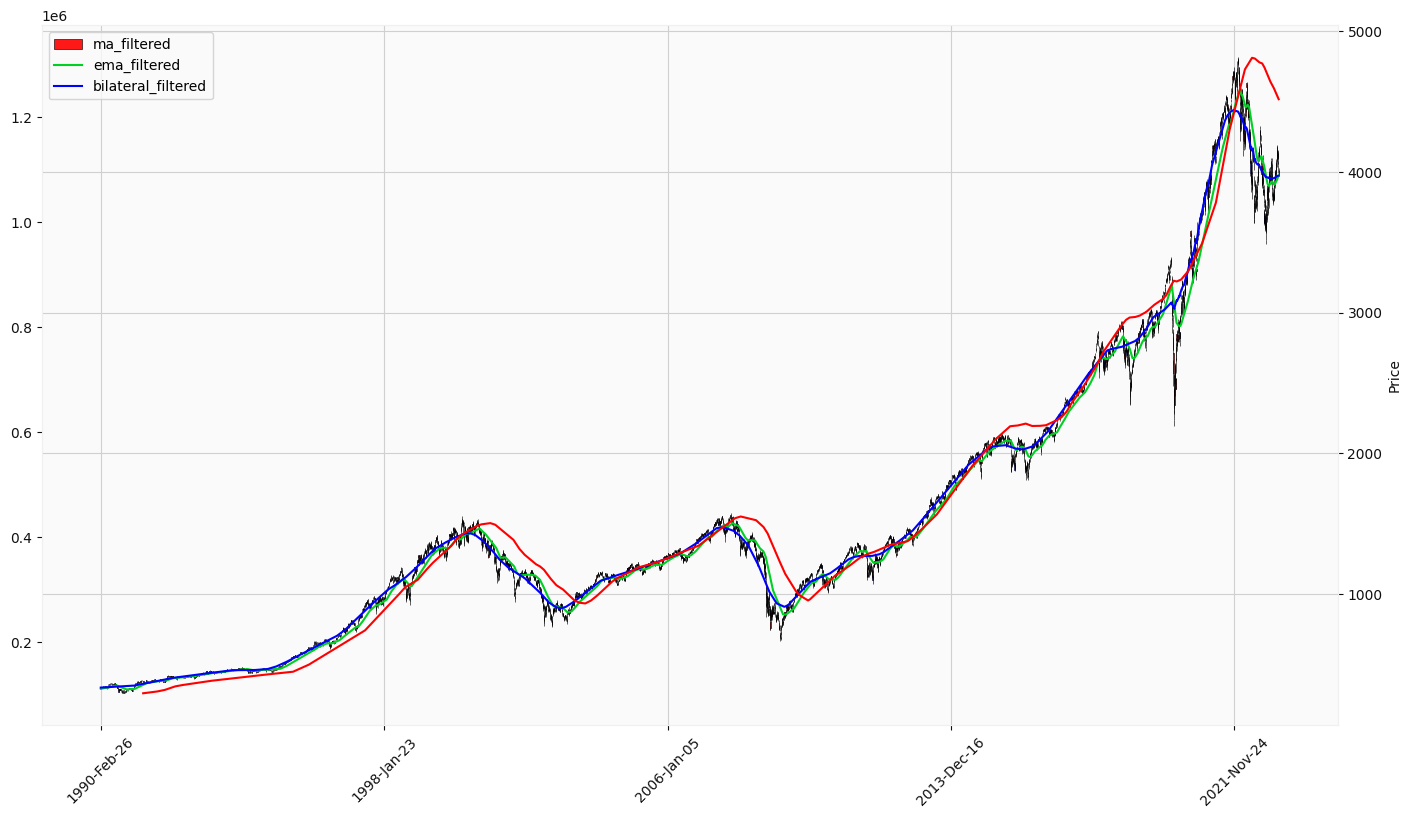

In [20]:
add_plots = {
    'ma_filtered': mpf.make_addplot(ma_filtered, type='line', color='r', width=1.5),
    'ema_filtered': mpf.make_addplot(ema_filtered, type='line', color='#00d024', width=1.5),
    'bilateral_filtered': mpf.make_addplot(bilateral_filtered, type='line', color='b', width=1.5),
}

fig, ax = candlechart(df, addplot=list(add_plots.values()))
fig.set_size_inches(18, 10)

ax[0].legend([None] * (len(add_plots) + 2))
handles = ax[0].get_legend().legendHandles
ax[0].legend(handles=handles[1:], labels=list(add_plots.keys()))